# Tuning

Okay. We wrangled some data; ran a simple prediction and then added some more data. Lets stop for a moment, before we add even more data; and do some preliminary work. 

> We'll firstly try to understand why [johnowhitaker](https://datasciencecastnet.home.blog/2019/10/19/zindi-uberct-part-1-getting-started/) recommends ```logloss``` as a metric. Then establish a baseline; so we know if we're improving; or not. And finally some basic parameter tuning.

*   ```learning_rate```;
*   ```n_estimators```;
*   ```min_child_weight```;
*   ```max_depth```;
*   ```gamma```;
*   ```colsample_bytree```;
*   ```subsample```; and
*   ```reg_alpha```.   

> NOTE: I'm not a data scientist nor a machine learing expert and will not attempt any ```up/down/re-sampling``` or other techniques, such as ```SMOTE```, to balance this extremely imbalanced dataset. I'll use the built in parameters (```scale_pos_weight```  and ```max_delta_step```) with a ```threshold``` to; hopefully, get a meaningful result. My aim here is to understand how this works.

*!!!! I had no idea ```parameter tuning``` was this time intensive. Running this ```notebook``` on a laptop will take more than a week !!!*

In [ ]:
#because we're on google colab
!pip install --upgrade pandas
!pip install --upgrade geopandas
#!pip install --upgrade seaborn

In [2]:
# import the modules that make the magic possible
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

import pickle
from joblib import dump

In [3]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from collections import Counter
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn import metrics 
from sklearn.metrics import f1_score, classification_report, auc, log_loss, accuracy_score, confusion_matrix, precision_score, mean_squared_error, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve, mean_absolute_error
from numpy import where, mean, sqrt, argmax, arange

In [ ]:
# mount google drive as a file system
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [5]:
#set path
path = Path('/content/gdrive/My Drive/Zindi_Accident')

In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/Zindi_Accident')

# load a custom confusion_matrix tool for plotting 
# courtesy - leportella (https://github.com/leportella/federal-road-accidents)
from tools import plot_confusion_matrix

#### Load the data

In [6]:
#load the train and test from the previous notebook
train = pd.read_csv(path/'data/train_with_weather.csv', parse_dates = ['datetime'])
test = pd.read_csv(path/'data/test_with_weather.csv', parse_dates = ['datetime'])

In [7]:
# define a list of column names to be used for training
x_cols = ['month', 'day', 'hour', 'longitude', 'latitude', 'WIDTH', 'LANES', 
          'Air_temp', 'Atmos_press', 'Atmos_press_MeanSea', 'Humidity', 'MeanWindSpeed', 'Visibility', 'DewPoint', 'Rainfall']

In [8]:
X, y = train[x_cols], train['y']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Instead of ```numpy``` arrays or ```pandas``` dataFrame, ```XGBoost``` uses ```DMatrices```.



In [10]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#### We've already seen how imbalanced the data is. Lets have another look.

In [ ]:
# summarize dataset
classes = np.unique(y)
total = len(y)
for c in classes:
	n_examples = len(y[y==c])
	percent = n_examples / total * 100
	print('> Class=%d : %d/%d (%.1f%%)' % (c, n_examples, total, percent))

> Class=0 : 4751754/4765984 (99.7%)
> Class=1 : 14230/4765984 (0.3%)


#### Now ```logloss```.  

> From 01_SimpleXGB.ipynb; we've seen that ```accuracy``` does us no good. Its always going to be in the ```99%``` because of the class imbalance. ```auc``` also proved extremly optomistic when compared to an ```f1_score``` (the competition requirement).

> We need another ```metric```. Following [johnowhitaker's](https://datasciencecastnet.home.blog/2019/10/19/zindi-uberct-part-1-getting-started/) lead; a crisp class label is not required; instead a probability of class membership is preferred. "*The probability summarizes the likelihood (or uncertainty) of an example belonging to each class label... [and is]... specifically designed to quantify the skill of a classifier model using the predicted probabilities instead of crisp class labels.*"

> Probability metrics will summarize how well the predicted distribution of class membership matches the known class probability distribution. 

> This is what we need. Thanks to [machinelearningmastery](https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/)
 

#### We can predict certain probabilities for class 0...

In [ ]:
# no skill prediction 0
probabilities = [[1, 0] for _ in range(len(y_test))]
avg_logloss = log_loss(y_test, probabilities)
print('P(class0=1): Log Loss=%.3f' % (avg_logloss))

P(class0=1): Log Loss=0.103


#### ...or class 1.


In [ ]:
# no skill prediction 1
probabilities = [[0, 1] for _ in range(len(y_test))]
avg_logloss = log_loss(y_test, probabilities)
print('P(class1=1): Log Loss=%.3f' % (avg_logloss))

P(class1=1): Log Loss=34.436


#### A better strategy would be to predict the class distribution.

In [ ]:
# baseline probabilities
probabilities = [[0.997, 0.003] for _ in range(len(y_test))]
avg_logloss = log_loss(y_test, probabilities)
print('Baseline: Log Loss=%.3f' % (avg_logloss))

Baseline: Log Loss=0.020


#### How do we know this is reliable?

In [ ]:
# perfect probabilities
avg_logloss = log_loss(y_test, y_test)
print('Perfect: Log Loss=%.3f' % (avg_logloss))

Perfect: Log Loss=0.000


#### We have a baseline; now some basic ```parameter``` tuning. 

> First we do a rough search for the optimal ```n_estimators``` (number of trees) given a range of ```learning_rate```. We'll refine it later but its a good starting point.

> #### Note: I've left the ```scale_pos_weight = 18.291```; as discussed in 01_SimpleXGBoost.ipynb. I've also changed the ```max_delta_step``` to a positive value (=1) as it can help with extremely imbalanced data; based on: [here](http://ethen8181.github.io/machine-learning/trees/xgboost.html#XGBoost-Basics) and [here](https://stats.stackexchange.com/questions/387632/running-xgboost-with-highly-imbalanced-data-returns-near-0-true-positive-rate).





In [ ]:
# define a model

xgb_rough = XGBClassifier(
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    max_delta_step=1,
    objective= 'binary:logistic',
    scale_pos_weight=18.291,
    seed=27)

In [ ]:
# kfold gridsearchcv

# which n_estimators do you want to search?
n_estimators = [100, 200, 300, 400, 500]
# which learning_rate do you want to search?
learning_rate = [0.1, 0.2, 0.3]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

kfold = StratifiedKFold(n_splits=2, shuffle=True)

grid_search = GridSearchCV(xgb_rough, param_grid, scoring="neg_log_loss", n_jobs=1, cv=kfold, verbose=2)

In [ ]:
#define evaluation metrics
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["logloss", 'error']

In [ ]:
%%time
grid_result = grid_search.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [ ]:
# save model to file
pickle.dump(xgb_rough, open(path/'xgb_rough.pickle.dat', 'wb'))

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.041012 using {'learning_rate': 0.3, 'n_estimators': 500}
-0.052577 (0.000264) with: {'learning_rate': 0.1, 'n_estimators': 100}
-0.050332 (0.000365) with: {'learning_rate': 0.1, 'n_estimators': 200}
-0.049081 (0.000282) with: {'learning_rate': 0.1, 'n_estimators': 300}
-0.048086 (0.000226) with: {'learning_rate': 0.1, 'n_estimators': 400}
-0.047011 (0.000253) with: {'learning_rate': 0.1, 'n_estimators': 500}
-0.050541 (0.000250) with: {'learning_rate': 0.2, 'n_estimators': 100}
-0.048202 (0.000200) with: {'learning_rate': 0.2, 'n_estimators': 200}
-0.046489 (0.000282) with: {'learning_rate': 0.2, 'n_estimators': 300}
-0.045070 (0.000216) with: {'learning_rate': 0.2, 'n_estimators': 400}
-0.043468 (0.000172) with: {'learning_rate': 0.2, 'n_estimators': 500}
-0.049265 (0.000138) with: {'learning_rate': 0.3, 'n_estimators': 100}
-0.046679 (0.000169) with: {'learning_rate': 0.3, 'n_estimators': 200}
-0.044662 (0.000250) with: {'learning_rate': 0.3, 'n_estimators': 300}
-0.042858 (

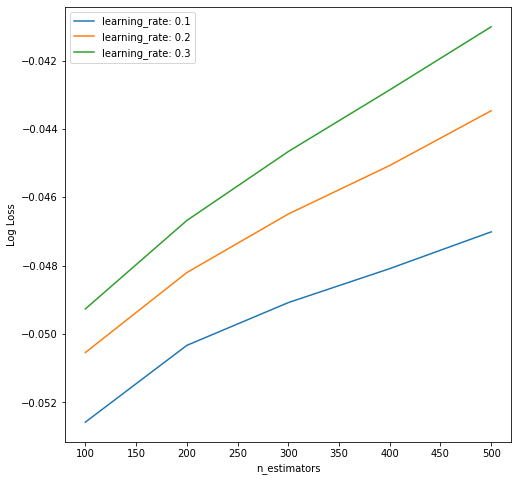

In [ ]:
# plot results
fig, ax = plt.subplots(figsize=(8,8))
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.show()

#### Due to memory limitations I'm choosing a ```learning_rate``` of ```0.3```. A lower ```learning_rate``` (```0.1```/```0.2```) will require to many trees, more RAM and more time. 

> Lets find the proper ```n_estimators```. We ```xgb.cv``` with 10 ```early_stopping_rounds```







In [ ]:
xgb_smooth = XGBClassifier(
    learning_rate=0.3,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    max_delta_step=1,
    objective= 'binary:logistic',
    scale_pos_weight=18.291,
    seed=27)

#collect parameters
xgb_param = xgb_smooth.get_xgb_params()

In [ ]:
%%time
cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_smooth.get_params()['n_estimators'], 
                  nfold=3,
                  metrics='logloss', early_stopping_rounds=10, verbose_eval=True)

In [ ]:
print('Best n_estimators =', cvresult.shape[0])

Best n_estimators = 339


In [ ]:
# add the  optimal n_estimators to the parameters
xgb_smooth.set_params(n_estimators=cvresult.shape[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.3, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=339, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=18.291, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [ ]:
#Fit the algorithm on the data
%time xgb_smooth.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [ ]:
# save model to file
pickle.dump(xgb_smooth, open(path/'xgb_smooth.dat', 'wb'))
 
# some time later...
 
# load model from file
#loaded_model = pickle.load(open(path/'sanral_with_weather.pickle.dat", "rb"))

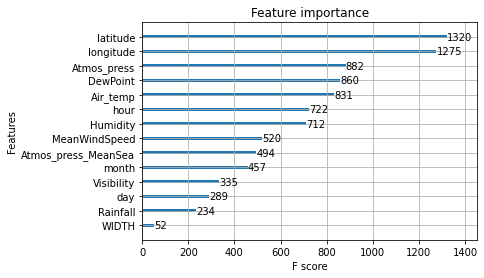

In [ ]:
plot_importance(xgb_smooth, max_num_features = 14)
plt.show()

In [ ]:
#Predict training set:
dtrain_predictions = xgb_smooth.predict(X_train)
train_pred = [round(value) for value in dtrain_predictions]
dtrain_predprob = xgb_smooth.predict_proba(X_train)[:,1]

#Predict training set:
dtest_predictions = xgb_smooth.predict(X_test)
test_pred = [round(value) for value in dtest_predictions]
dtest_predprob = xgb_smooth.predict_proba(X_test)[:,1]

In [ ]:
#Print model report:
print("\nModel Report")
print("Training Accuracy : %.4g" % accuracy_score(y_train.values, train_pred))
#print("Training Accuracy : %.4g" % accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train): %f" % roc_auc_score(y_train, dtrain_predprob))
print("logloss (Train): %f" % log_loss(y_train, dtrain_predprob))
print("Preliminary f1-score (Train): %f" %f1_score(y_train, dtrain_predictions))
print('')
print("Test Accuracy : %.4g" % accuracy_score(y_test.values, test_pred))
#print("Test Accuracy : %.4g" % accuracy_score(y_test.values, dtest_predictions))
print("AUC Score (Test): %f" % roc_auc_score(y_test, dtest_predprob))
print("logloss (Test): %f" % log_loss(y_test, dtest_predprob))
print("Preliminary f1-score (Test): %f" %f1_score(y_test, dtest_predictions))


Model Report
Training Accuracy : 0.9938
AUC Score (Train): 0.950906
logloss (Train): 0.044265
Preliminary f1-score (Train): 0.202707

Test Accuracy : 0.9936
AUC Score (Test): 0.893693
logloss (Test): 0.046068
Preliminary f1-score (Test): 0.147202


#### ```logarithmic loss``` of the XGBoost model for each epoch on the training and test datasets.



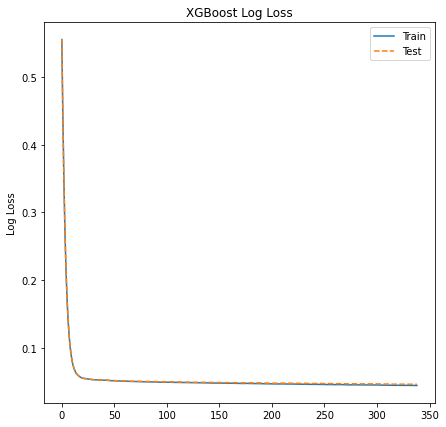

In [ ]:
# retrieve performance metrics
results = xgb_smooth.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(x_axis, results['validation_0']['logloss'], linestyle = '-', label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], linestyle = '--', label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

#### Good. Lets move along to ```max_depth``` (*represents the depth of each tree, and is the maximum number of different features used in each tree - it will help simplify your model and avoid overfitting*) and ```min_child_weight```.

> Again we firstly do a rough search along a ```range``` of values; then iteratively refine.



In [ ]:
param_test1 = {
    'max_depth':range(3,11,3),
    'min_child_weight':range(1,9,3)
    }

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.3, n_estimators=339, max_depth=5, max_delta_step=1,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', scale_pos_weight=18.291, seed=27),
                        param_grid = param_test1, scoring='neg_log_loss',n_jobs=1, cv=2, verbose=2)

In [ ]:
%%time
gsearch1.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [ ]:
# save model to file
#pickle.dump(gsearch1, open(path/'gsearch1.pickle.dat', 'wb'))

# load model from file
gsearch1 = pickle.load(open(path/'gsearch1.pickle.dat', "rb"))

In [ ]:
# summarize results
print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))
means = gsearch1.cv_results_['mean_test_score']
stds = gsearch1.cv_results_['std_test_score']
params = gsearch1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.023701 using {'max_depth': 9, 'min_child_weight': 1}
-0.049956 (0.000155) with: {'max_depth': 3, 'min_child_weight': 1}
-0.050117 (0.000236) with: {'max_depth': 3, 'min_child_weight': 4}
-0.050027 (0.000244) with: {'max_depth': 3, 'min_child_weight': 7}
-0.039102 (0.000395) with: {'max_depth': 6, 'min_child_weight': 1}
-0.039416 (0.000133) with: {'max_depth': 6, 'min_child_weight': 4}
-0.039644 (0.000455) with: {'max_depth': 6, 'min_child_weight': 7}
-0.023701 (0.000171) with: {'max_depth': 9, 'min_child_weight': 1}
-0.024502 (0.000194) with: {'max_depth': 9, 'min_child_weight': 4}
-0.025348 (0.000244) with: {'max_depth': 9, 'min_child_weight': 7}


#### A graph is always useful

In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
  '''
  Define a function to plot search parameters vs cv_results
  '''
  # Get Test Scores Mean and std for each grid search
  scores_mean = cv_results['mean_test_score']
  scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

  scores_sd = cv_results['std_test_score']
  scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

  # Plot Grid search scores
  _, ax = plt.subplots(1,1)

  # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
  for idx, val in enumerate(grid_param_2):
    ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

  ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
  ax.set_xlabel(name_param_1, fontsize=16)
  ax.set_ylabel('CV Average Score', fontsize=16)
  ax.legend(fontsize=15, bbox_to_anchor=(1.04,0.5), loc="center left")
  ax.grid('on')

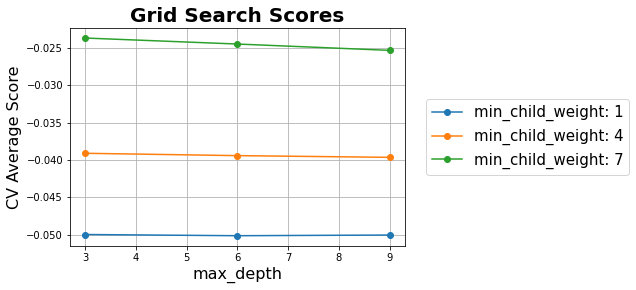

In [ ]:
# Calling Method 
plot_grid_search(gsearch1.cv_results_, param_test1['max_depth'],
                 param_test1['min_child_weight'], 'max_depth', 'min_child_weight')

#### We ```fit 2 folds for each of 9 candidates, totalling 18``` combinations with an interval of ```3```. The ideal values are ```9``` for ```max_depth``` and ```1``` for ```min_child_weight```. Now we search with a different range. The idea here is to iterately narrow the search space.

> A ```GridSearch```, through the entire parameter range ```[1, 10]```, with a ```step``` of ```1``` takes to long (*+12-hours*). I prefer this method.



In [ ]:
param_test2 = {
    'max_depth':range(2,11,3),
    'min_child_weight':range(2,11,3)
    }

gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.3, n_estimators=339, max_depth=5, max_delta_step=1,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', scale_pos_weight=18.291, seed=27),
                        param_grid = param_test2, scoring='neg_log_loss',n_jobs=1, cv=2, verbose=2)

In [ ]:
%%time
gsearch2.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [ ]:
# save model to file
pickle.dump(gsearch2, open(path/'gsearch2.pickle.dat', 'wb'))

In [ ]:
# summarize results
print("Best: %f using %s" % (gsearch2.best_score_, gsearch2.best_params_))
means = gsearch2.cv_results_['mean_test_score']
stds = gsearch2.cv_results_['std_test_score']
params = gsearch2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.027594 using {'max_depth': 8, 'min_child_weight': 2}
-0.052217 (0.000195) with: {'max_depth': 2, 'min_child_weight': 2}
-0.052224 (0.000226) with: {'max_depth': 2, 'min_child_weight': 5}
-0.052232 (0.000235) with: {'max_depth': 2, 'min_child_weight': 8}
-0.043810 (0.000327) with: {'max_depth': 5, 'min_child_weight': 2}
-0.043934 (0.000358) with: {'max_depth': 5, 'min_child_weight': 5}
-0.044145 (0.000328) with: {'max_depth': 5, 'min_child_weight': 8}
-0.027594 (0.000508) with: {'max_depth': 8, 'min_child_weight': 2}
-0.028331 (0.000233) with: {'max_depth': 8, 'min_child_weight': 5}
-0.029510 (0.000137) with: {'max_depth': 8, 'min_child_weight': 8}


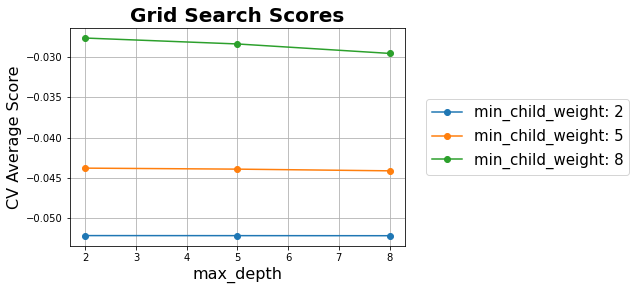

In [ ]:
# call the plot 
plot_grid_search(gsearch2.cv_results_, param_test2['max_depth'],
                 param_test2['min_child_weight'], 'max_depth', 'min_child_weight')

#### We see from: ```2 folds for each of 9 candidates, totalling 18 fits```  with an interval of ```3```; the ideal values are ```8``` for ```max_depth``` and ```2``` for ```min_child_weight```.

#### Now we search between this result; and the previous.



In [ ]:
param_test3 = {
    'max_depth':[8,9],
    'min_child_weight':[1,2]
    }

gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.3, n_estimators=339, max_depth=5, max_delta_step=1,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', scale_pos_weight=18.291, seed=27),
                        param_grid = param_test3, scoring='neg_log_loss',n_jobs=1, cv=2, verbose=2)

In [ ]:
%%time
gsearch3.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [ ]:
# save model to file
pickle.dump(gsearch3, open(path/'gsearch3.pickle.dat', 'wb'))

In [ ]:
# summarize results
print("Best: %f using %s" % (gsearch3.best_score_, gsearch3.best_params_))
means = gsearch3.cv_results_['mean_test_score']
stds = gsearch3.cv_results_['std_test_score']
params = gsearch3.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.023701 using {'max_depth': 9, 'min_child_weight': 1}
-0.027215 (0.000358) with: {'max_depth': 8, 'min_child_weight': 1}
-0.027594 (0.000508) with: {'max_depth': 8, 'min_child_weight': 2}
-0.023701 (0.000171) with: {'max_depth': 9, 'min_child_weight': 1}
-0.023953 (0.000239) with: {'max_depth': 9, 'min_child_weight': 2}


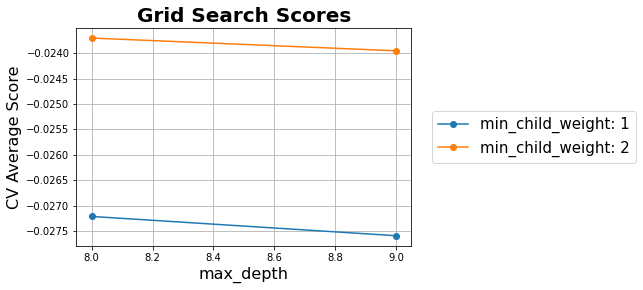

In [ ]:
# call the plot 
plot_grid_search(gsearch3.cv_results_, param_test3['max_depth'],
                 param_test3['min_child_weight'], 'max_depth', 'min_child_weight')

#### We have ```max_depth```: 9 and ```min_child_weight```: 1.

#### Now lets tune ```gamma``` using the parameters above. ```gamma``` can take various values but we'll check for 2 values <> More values require more ```tuning``` time. 

In [ ]:
param_test4 = {
    'gamma':[i/10.0 for i in range(0,2)]
    }

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.3, n_estimators=339, max_depth=9, max_delta_step=1, 
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', scale_pos_weight=18.291, seed=27), 
                        param_grid = param_test4, scoring='neg_log_loss',n_jobs=1, cv=3, verbose=2)

In [ ]:
%%time
gsearch4.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [ ]:
# save model to file
pickle.dump(gsearch4, open(path/'gsearch4.pickle.dat', 'wb'))

In [ ]:
# summarize results
print("Best: %f using %s" % (gsearch4.best_score_, gsearch4.best_params_))
means = gsearch4.cv_results_['mean_test_score']
stds = gsearch4.cv_results_['std_test_score']
params = gsearch4.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.025073 using {'gamma': 0.0}
-0.025073 (0.000171) with: {'gamma': 0.0}
-0.025235 (0.000305) with: {'gamma': 0.1}


#### As we can see our optimum value for ```gamma``` should be 0.

#### Before proceeding, a good idea would be to re-calibrate the number of ```n_estimators``` for the updated parameters.

In [12]:
#re-calibrate n_estimators
xgb_smooth = XGBClassifier(
    learning_rate=0.3,
    n_estimators=1000,
    max_depth=9,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    max_delta_step=1,
    objective= 'binary:logistic',
    scale_pos_weight=18.291,
    seed=27)

#collect parameters
xgb_param = xgb_smooth.get_xgb_params()

In [ ]:
%%time
cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_smooth.get_params()['n_estimators'], 
                  nfold=3,
                  metrics='logloss', early_stopping_rounds=10, verbose_eval=True)

In [14]:
print('Best n_estimators =', cvresult.shape[0])

Best n_estimators = 495


In [ ]:
# add the optimal n_estimators to the parameters
xgb_smooth.set_params(n_estimators=cvresult.shape[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.3, max_delta_step=1, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=495, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=18.291, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [ ]:
#Fit the algorithm on the data
%time xgb_smooth.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

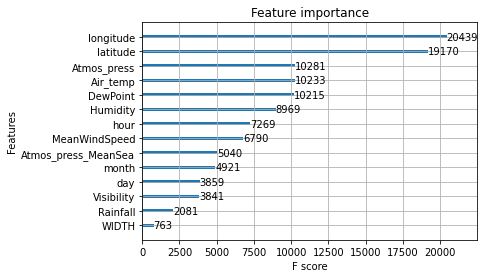

In [ ]:
plot_importance(xgb_smooth, max_num_features = 14)
plt.show()

In [ ]:
#Predict training set:
dtrain_predictions = xgb_smooth.predict(X_train)
train_pred = [round(value) for value in dtrain_predictions]
#only the positive class
dtrain_predprob = xgb_smooth.predict_proba(X_train)[:,1]

#Predict test set:
dtest_predictions = xgb_smooth.predict(X_test)
test_pred = [round(value) for value in dtest_predictions]
#only the positive class
dtest_predprob = xgb_smooth.predict_proba(X_test)[:,1]

In [ ]:
#Print model report:
print("\nModel Report")
print("Training Accuracy : %.4g" % accuracy_score(y_train.values, train_pred))
#print("Training Accuracy : %.4g" % accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train): %f" % roc_auc_score(y_train, dtrain_predprob))
print("logloss (Train): %f" % log_loss(y_train, dtrain_predprob))
print("Preliminary f1-score (Train): %f" %f1_score(y_train, dtrain_predictions))
print('')
print("Test Accuracy : %.4g" % accuracy_score(y_test.values, test_pred))
#print("Test Accuracy : %.4g" % accuracy_score(y_test.values, dtest_predictions))
print("AUC Score (Test): %f" % roc_auc_score(y_test, dtest_predprob))
print("logloss (Test): %f" % log_loss(y_test, dtest_predprob))
print("Preliminary f1-score (Test): %f" %f1_score(y_test, dtest_predictions))


Model Report
Training Accuracy : 0.9977
AUC Score (Train): 0.999670
logloss (Train): 0.011462
Preliminary f1-score (Train): 0.715188

Test Accuracy : 0.9941
AUC Score (Test): 0.871200
logloss (Test): 0.024662
Preliminary f1-score (Test): 0.121796


## NB: I stopped ```parameter tuning``` here; and proceeded onto ```Plot ROC curves```...

#### The rest of the ```code``` between here and there - *and most of the above is thanks to [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)* - is to complete the ```tuning```; which I might do at another time.


#### The next step would be try different ```subsample``` and ```colsample_bytree``` values.

> We search values from 0.8 to 1 for ```subsample``` and 0.5 through 1 for ```colsample_bytree``` because although we have not  ```one-hot-encoded``` we do have 14 columns  - and will add more.



In [ ]:
param_test5 = {
    'subsample':[i/10.0 for i in range(8,11)],
    'colsample_bytree':[i/10.0 for i in range(5,11)]
    }

gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.3, n_estimators=353, max_depth=9, max_delta_step=1, 
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', scale_pos_weight=18.291, seed=27), 
                        param_grid = param_test5, scoring='neg_log_loss',n_jobs=1, cv=2, verbose=2)

In [ ]:
%%time
gsearch5.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [ ]:
# save model to file
pickle.dump(gsearch5, open(path/'gsearch5.pickle.dat', 'wb'))

In [ ]:
# summarize results
print("Best: %f using %s" % (gsearch5.best_score_, gsearch5.best_params_))
means = gsearch5.cv_results_['mean_test_score']
stds = gsearch5.cv_results_['std_test_score']
params = gsearch5.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
param_test6 = {
    'colsample_bytree':[i/10.0 for i in range(5,11)]
    }

gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.3, n_estimators=353, max_depth=5, max_delta_step=1, 
                                                  min_child_weight=6, gamma=0.1, subsample=1.0, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', scale_pos_weight=18.291,seed=27), 
                        param_grid = param_test6, scoring='neg_log_loss',n_jobs=1, cv=2, verbose=2)

In [ ]:
%%time
gsearch6.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [ ]:
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

#### Our last parameter is to apply regularization which can reduce overfitting. Though  ```gamma``` is more popular and provides a substantial way of controlling complexity; we should try ```reg_alpha```.

In [ ]:
param_test7 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
    }

gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.3, n_estimators=353, max_depth=5, max_delta_step=1, 
                                                  min_child_weight=6, gamma=0.1, subsample=1.0, colsample_bytree=1.0,
                                                  objective= 'binary:logistic', scale_pos_weight=18.291, seed=27), 
                        param_grid = param_test7, scoring='neg_log_loss', n_jobs=1, cv=2, verbose=2)

In [ ]:
%%time
gsearch7.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [ ]:
# summarize results
print("Best: %f using %s" % (gsearch7.best_score_, gsearch7.best_params_))
means = gsearch7.cv_results_['mean_test_score']
stds = gsearch7.cv_results_['std_test_score']
params = gsearch7.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

#### Now lets calculate a threshold and make a prediction.

In [ ]:
#change these to what they should be
model = XGBClassifier(
    learning_rate=0.2,
    n_estimators=353,
    max_depth=5,
    min_child_weight=6,
    gamma=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    max_delta_step=1,
    objective= 'binary:logistic',
    scale_pos_weight=1,
    reg_alpha=0,
    seed=27)

In [ ]:
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=2)

#### ```most_important``` features

In [ ]:
plot_importance(model, max_num_features = 14)
plt.show()

In [ ]:
#lets predict *PROBABILITIES*  on the training-set
y_pred_train = xgb_smooth.predict_proba(X_train)
# keep probabilities for the positive outcome only
y_pred_train = y_pred_train[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)

#lets predict *PROBABILITIES*  on the test-set
y_pred_test = xgb_smooth.predict_proba(X_test)
# keep probabilities for the positive outcome only
y_pred_test = y_pred_test[:, 1]
# calculate roc curves
fpr_t, tpr_t, thresholds_t = roc_curve(y_test, y_pred_test)

In [ ]:
print('Training log_loss:', log_loss(y_train, y_pred_train))
print('')
print('Test log_loss:', log_loss(y_test, y_pred_test))

Training log_loss: 0.01146151415275742

Test log_loss: 0.02466166642416993


#### Plot ROC curves for both the ```training``` and ```test``` datasets


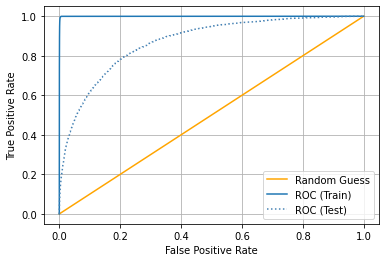

In [ ]:
#plot
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange')#,lw=3)
plt.plot(fpr,tpr,label='ROC (Train)')#,lw=3)
plt.plot(fpr_t,tpr_t,'r:',label='ROC (Test)',color='steelblue')#,lw=3)
#pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Train')
#pyplot.scatter(fpr_test[ix_t], tpr_test[ix_t], marker='o', color='red', label='Best Test')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Precision-Recall Curve

In [ ]:
#for the training
# predict class values
yhat = xgb_smooth.predict(X_train)
lr_precision, lr_recall, thresh = precision_recall_curve(y_train, y_pred_train)
lr_f1, lr_auc = f1_score(y_train, yhat), auc(lr_recall, lr_precision)
# summarize scores
print(' Training Classification: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('')
#for the training
# predict class values
yhat_t = xgb_smooth.predict(X_test)
lr_precision_t, lr_recall_t, thresh_t = precision_recall_curve(y_test, y_pred_test)
lr_f1_t, lr_auc_t = f1_score(y_test, yhat_t), auc(lr_recall_t, lr_precision_t)
# summarize scores
print(' Test Classification: f1=%.3f auc=%.3f' % (lr_f1_t, lr_auc_t))

 Training Classification: f1=0.715 auc=0.867

 Test Classification: f1=0.122 auc=0.050


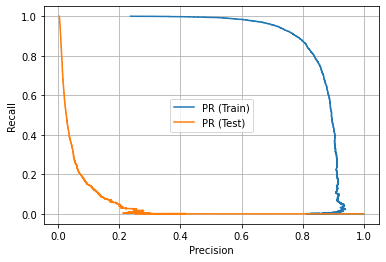

In [ ]:
#plot
fig,ax = plt.subplots()
plt.plot(lr_precision,lr_recall,label='PR (Train)')#,lw=3)
plt.plot(lr_precision_t,lr_recall_t,label='PR (Test)')#,lw=3)
#pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best Training')
#pyplot.scatter(recall_test[ix_t], precision_test[ix_t], marker='o', color='red', label='Best Test')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.show()

#### Optimal Threshold

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


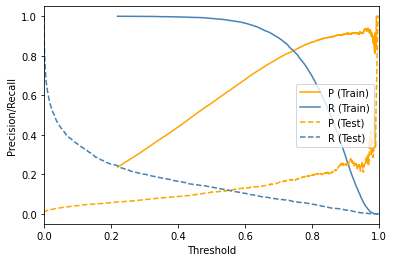

In [ ]:
# threshold plot
plt.plot(thresh,lr_precision[:-1],'r-',label='P (Train)',color='orange')#,lw=3)
plt.plot(thresh,lr_recall[:-1],'r-',label='R (Train)',color='steelblue')#,lw=3)
plt.plot(thresh_t,lr_precision_t[:-1],'--',label='P (Test)',color='orange')
plt.plot(thresh_t,lr_recall_t[:-1],'--',label='R (Test)',color='steelblue')
#plt.plot([0,1],[0,1],'k-',lw=2)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

#### Threshold Tuning for F1-Score

In [ ]:
# apply threshold to predictions to create labels
def to_labels(pos_preds, threshold):
  '''
  define a function to take the prediction and threshold as an argument and return an array of integers in {0, 1}
  '''
  return (pos_preds >= threshold).astype(int)

In [ ]:
# define thresholds (start, stop, step)
threshold = np.arange(0, 1, 0.002)

# evaluate each threshold
scores = [f1_score(y_train, to_labels(y_pred_train, t)) for t in threshold]

# get best threshold
ix = argmax(scores)
print('Training Threshold = %.3f, F-Score = %.5f' % (threshold[ix], scores[ix]))

Training Threshold = 0.700, F-Score = 0.83670


## Predicting

#### First on the ```train``` - 2017.

In [ ]:
print('Predicting on the Training-set with a Threshold of = %.3f' % 0.700)
train['pred'] = (xgb_smooth.predict(train[x_cols]) > 0.70).astype(int)
print(' Accuracy:',accuracy_score(train['y'],train['pred']))
#rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (mean_squared_error(train['y'],train['pred'])))
print(' f1-score for the + class:',f1_score(train['y'],train['pred']))
print(' Precision for the + class:',precision_score(train['y'],train['pred']))
print(' Recall for the + class:',recall_score(train['y'],train['pred']))
#y_pred_train = model.predict(train[x_cols])
print(' AUC:',roc_auc_score(train['y'],train['pred']))
print(' Ave. Precision:',average_precision_score(train['y'],train['pred']))
#train.head(3)

Predicting on the Training-set with a Threshold of = 0.700
 Accuracy: 0.9967660403392038
RMSE: 0.003234
 f1-score for the + class: 0.5884928580963823
 Precision for the + class: 0.4745317545748116
 Recall for the + class: 0.7744905130007027
 AUC: 0.8859610991134159
 Ave. Precision: 0.36819365524873865


Confusion matrix, without normalization
[[4739550   12204]
 [   3209   11021]]


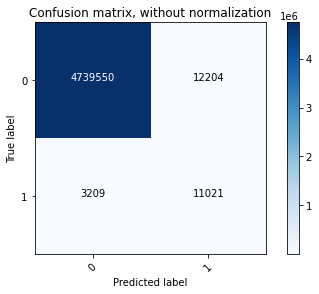

In [ ]:
cnf_matrix = confusion_matrix(train['y'], train['pred'])
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix, without normalization')

In [ ]:
#have a look at the built-in report
print(classification_report(train['y'], train['pred']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4751754
           1       0.47      0.77      0.59     14230

    accuracy                           1.00   4765984
   macro avg       0.74      0.89      0.79   4765984
weighted avg       1.00      1.00      1.00   4765984



### Now our personal ```test``` - 4 months towards the end of 2018.

In [ ]:
print('Predicting on the Test-set with a Threshold of = %.3f' % 0.700)
test['pred'] = (xgb_smooth.predict(test[x_cols]) > 0.700).astype(int)
print (' Accuracy:',accuracy_score(test['y'],test['pred']))
#rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (mean_squared_error(test['y'], test['pred'])))
print (' f1-score for the + class:',f1_score(test['y'],test['pred']))
print (' Precision for the + class:',precision_score(test['y'],test['pred']))
print (' Recall for the + class:',recall_score(test['y'],test['pred']))
#y_pred_test = model.predict(test[x_cols])
print (' AUC:',roc_auc_score(test['y'],test['pred']))
print (' Ave. Precision:',average_precision_score(test['y'],test['pred']))

Predicting on the Test-set with a Threshold of = 0.700
 Accuracy: 0.9933494482130202
RMSE: 0.006651
 f1-score for the + class: 0.02613046701260193
 Precision for the + class: 0.06485740570377185
 Recall for the + class: 0.016361104664655374
 AUC: 0.5075338012306558
 Ave. Precision: 0.006425242275711815


Confusion matrix, without normalization
[[1569669    2033]
 [   8477     141]]


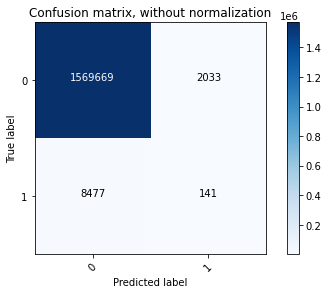

In [ ]:
cnf_matrix = confusion_matrix(test['y'], test['pred'])
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix, without normalization')

In [ ]:
#have a look at the built-in report
print(classification_report(test['y'], test['pred']))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1571702
           1       0.06      0.02      0.03      8618

    accuracy                           0.99   1580320
   macro avg       0.53      0.51      0.51   1580320
weighted avg       0.99      0.99      0.99   1580320



In [ ]:
print(len(prediction))
good = prediction.loc[prediction['pred'] == 1]
print(len(good))

In [ ]:
good.head(2)

In [ ]:
#save it
good[['segment_id', 'year', 'month', 'day', 'hour', 'latitude', 'longitude']].to_csv(path/'data/03_XGBoostTuning.csv', 
                                                                                                 index=False)